In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


import os

print(os.listdir("../input"))

['ibm-fire-no-fire-feature-best-map', 'ibm-fire-dataset-builder-3-6-hr', 'ibm-fire-no-fire-feature-and-threshold-optim']


### Unfortunatelly this dataset was saved without inverse scaling, so have to make the same scaller from the original data

In [2]:
df_d = pd.read_csv(
    "../input/ibm-fire-dataset-builder-3-6-hr/basegrid_12h.csv",
    index_col=["timestamp", "lat", "lon"],
    usecols=["timestamp", "lat", "lon", "PRECTOT", "fire_count"],
)
df_d.shape

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2233460, 2)

In [3]:
df_d["fire_count"] = df_d["fire_count"].replace(-20, -1)
df_d["fire_count"].describe()

count    2.233460e+06
mean    -9.392149e-01
std      7.881471e-01
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      1.670000e+02
Name: fire_count, dtype: float64

In [4]:
scaler_label = StandardScaler()
# only fit, we don't want to transform here
scaler_label.fit(df_d.loc[:, df_d.columns == "fire_count"])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [5]:
# ok, this is the transform in the original kernel
df_d["fire_count"].describe()

count    2.233460e+06
mean    -9.392149e-01
std      7.881471e-01
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      1.670000e+02
Name: fire_count, dtype: float64

### Read the fire potential dataset and convert to pandas

In [6]:
file = "../input/ibm-fire-no-fire-feature-best-map/start_2010-02-01_00h_step_12h.pickle_commit5"

with open(file, mode="rb") as file:
    pred = pickle.load(file)

In [7]:
pred.shape

(6510, 20, 17)

In [8]:
# inverse transform pred
# drop unecessary dimensions for easier handling
pred = scaler_label.inverse_transform(pred)
pred = pred.squeeze()
pred.shape

(6510, 20, 17)

In [9]:
lat = [
    32.5,
    33.0,
    33.5,
    34.0,
    34.5,
    35.0,
    35.5,
    36.0,
    36.5,
    37.0,
    37.5,
    38.0,
    38.5,
    39.0,
    39.5,
    40.0,
    40.5,
    41.0,
    41.5,
    42.0,
]
lon = [
    -123.75,
    -123.125,
    -122.5,
    -121.875,
    -121.25,
    -120.625,
    -120.0,
    -119.375,
    -118.75,
    -118.125,
    -117.5,
    -116.875,
    -116.25,
    -115.625,
    -115.0,
    -114.375,
    -113.75,
]
time_zero = "2010-02-01 00:00:00"
step_h = 12

In [10]:
dt = datetime.datetime.strptime(time_zero, "%Y-%m-%d %H:%M:%S")
step = datetime.timedelta(hours=12)

In [11]:
dates = [(dt + i * step) for i in range(pred.shape[0])]

In [12]:
iterables = [dates, lat, lon]
index = pd.MultiIndex.from_product(iterables, names=["time", "lat", "lon"])

In [14]:
df = pd.DataFrame(pred.flatten(), index=index)

In [15]:
df.reset_index(inplace=True)

In [16]:
df = df.rename(columns={0: "fire_potential"})

In [17]:
df.head()

,time,lat,lon,fire_potential
0,2010-02-01,32.5,-123.750,-0.971379
1,2010-02-01,32.5,-123.125,-0.992738
2,2010-02-01,32.5,-122.500,-0.999096
3,2010-02-01,32.5,-121.875,-0.976892
4,2010-02-01,32.5,-121.250,-1.022281


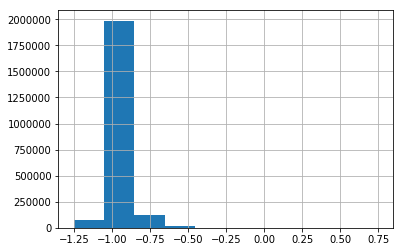

In [18]:
# ok, this is the required distribution
df["fire_potential"].hist()

In [19]:
# from the resource kernel
best_threshold = -0.8852528393268586

In [20]:
df.shape

(2213400, 4)

In [21]:
df[df["fire_potential"] > best_threshold].shape

(197120, 4)

In [22]:
# the threshold for the upper 90 percent of fiery cells, good for
max_color = df[df["fire_potential"] > best_threshold]["fire_potential"].quantile(0.95)
max_color

-0.5760710656642917

In [23]:
df.head()

,time,lat,lon,fire_potential
0,2010-02-01,32.5,-123.750,-0.971379
1,2010-02-01,32.5,-123.125,-0.992738
2,2010-02-01,32.5,-122.500,-0.999096
3,2010-02-01,32.5,-121.875,-0.976892
4,2010-02-01,32.5,-121.250,-1.022281


In [24]:
df["fire_potential"].describe()

count    2.213400e+06
mean    -9.726274e-01
std      8.471677e-02
min     -1.253478e+00
25%     -1.007995e+00
50%     -9.876888e-01
75%     -9.630947e-01
max      7.473089e-01
Name: fire_potential, dtype: float64

In [25]:
df.to_csv(
    "start_2010-02-01_00h_step_12h_pred_noinputfire_th_min08853_colormax_min06308.csv",
    index=False,
)

In [26]:
# shift fire_potential scale in order to use negative numbers as non-fire, and positive as fire
df["fire_potential"] = df["fire_potential"] - best_threshold

In [27]:
# as fires are above zero we search the upper 0.9 percentile to use as the top fiery limit
upper_limit = df[df["fire_potential"] > 0]["fire_potential"].quantile(0.95)
upper_limit

0.309181773662567

In [28]:
# 8 is the max of Rachel's colorbar
multiplier = 8 / upper_limit
multiplier

25.87474644844684

In [29]:
# scale up to Rachel's colorbar
df["fire_potential"] = df["fire_potential"] * multiplier

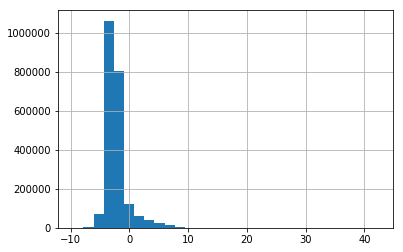

In [30]:
df["fire_potential"].hist(bins=30)

In [31]:
df.tail()

,time,lat,lon,fire_potential
2213395,2018-12-30 12:00:00,42.0,-116.250,-2.975988
2213396,2018-12-30 12:00:00,42.0,-115.625,-1.912581
2213397,2018-12-30 12:00:00,42.0,-115.000,-1.943005
2213398,2018-12-30 12:00:00,42.0,-114.375,-1.941054
2213399,2018-12-30 12:00:00,42.0,-113.750,-2.464001


In [32]:
df.to_csv(
    "start_2010-02-01_00h_step_12h_pred_noinputfire_shifted_to_zero_scaled_up_to_8.csv",
    index=False,
)

In [33]:
def map_with_heatmap(df, value, annot=False, cmap="tab20b", aggfunc=np.sum):
    map_df = df.pivot_table(index="lat", columns="lon", values=value, aggfunc=aggfunc)
    f, ax = plt.subplots(figsize=(9, 9))
    sns.heatmap(
        map_df, annot=annot, cmap=cmap, annot_kws={"fontsize": 8}, linewidths=0.0, ax=ax
    )
    ax.invert_yaxis()

In [34]:
df_test = df[df["time"] == "2016-04-21 12:00:00"]

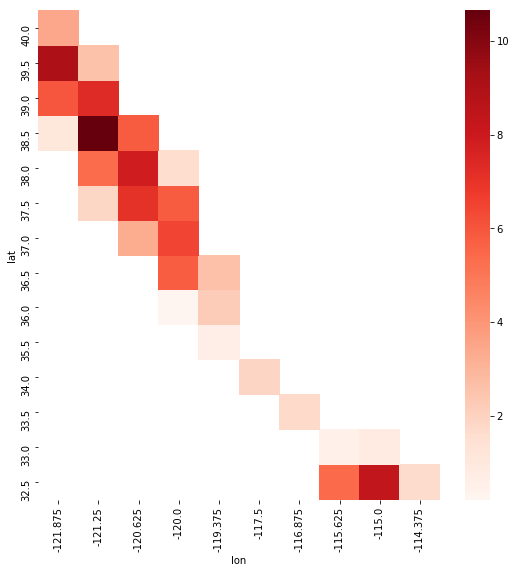

In [35]:
map_with_heatmap(
    df_test[df_test["fire_potential"] > 0],
    value="fire_potential",
    annot=False,
    cmap="Reds",
    aggfunc=np.mean,
)